In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matlab_lib import loadmat
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

def metric(t1, t2):
    ord12 = (t1 < t2).astype(float)
    return np.abs(2*np.mean(ord12) - 1)

def empirical_bounds(data, p):
    dataSorted = np.sort(data)
    nData = len(data)
    nBound = int(p*nData)
    return dataSorted[nBound], dataSorted[-nBound]

# Convert data to probability distribution
def rescale(x, p):
    #xnorm = x - np.min(x)         # Subtract minimum
    xnorm = x - np.percentile(x, p)  # Subtract percentile to arrive at baseline
    xnorm[xnorm < 0] = 0
    return xnorm / np.sum(xnorm)  # Normalize

# Cycle data backwards by n steps
def cycle_data(x, n):
    return np.hstack((x[n:], x[:n]))

def CDF(p):
    rez = np.zeros(len(p) + 1)
    for i in range(len(p)):
        rez[i+1] = rez[i] + p[i]
    return rez

def order_func(pvec):
    nNode = pvec.shape[0]
    cdfVec = [CDF(p) for p in pvec]
    
    ord1D = np.zeros((nNode, nNode))
    for i in range(nNode):
        for j in range(nNode):
            ord1D[i, j] += [np.sum(cdfVec[i] - cdfVec[j]) > 0]
    return ord1D

# Compute metric from comparisons matrix
# Comparisons matrix dimensions [nTrial, nCell, nCell]
def order_metric(comparisonsByTrial):
    phat = np.mean(comparisonsByTrial, axis=0)
    metricByConn = np.abs(2*phat - 1)
    metricByConn[np.eye(nCell, dtype=bool)] = 0  # Set diagonal to zero
    return metricByConn

# Compute clustering given distance matrix and distance threshold
def cluster_dist_matrix(M, nCluster):
    distTril = np.tril(metricByConn, 1)
    linkageMatrix = linkage(distTril, method='weighted', metric='euclidean')
    return fcluster(linkageMatrix, nCluster, criterion='maxclust') - 1  # Original numbering starts at 1 for some reason

def orderability_plots(metricByConn, thrBi):
    metricByConnOffDiag     = metricByConn[~np.eye(nCell, dtype=bool)]
    meanMetricByCell        = np.sum(metricByConn, axis=0) / (nCell-1)
    meanMetricByCellSorted  = np.sort(meanMetricByCell)
    meanMetricByCellSortIdx = np.argsort(meanMetricByCell)
    
    print("Mean order param", np.mean(metricByConnOffDiag))
    print("Number above 1%", np.mean(metricByConnOffDiag > thrBi))
    
    fig, ax = plt.subplots(ncols=4, figsize=(16,4))
    fig.suptitle(dataLabel)
    ax[0].set_title("Orderability by connection")
    ax[0].hist(metricByConnOffDiag, bins='auto')
    ax[0].axvline(x = thrBi, linestyle='--', color='y', label='p=1%')
    ax[0].legend()
    ax[0].set_xlim(0,1)
    ax[1].set_title("Orderability matrix")
    ax[1].imshow(metricByConn, vmin=0, vmax=1)
    ax[2].set_title("Mean orderability by cell, sorted")
    ax[2].plot(meanMetricByCellSorted)
    ax[3].set_title("Orderability matrix, sorted")
    ax[3].imshow(metricByConn[meanMetricByCellSortIdx][:, meanMetricByCellSortIdx], vmin=0, vmax=1)
    
def clustering_plots(matRescaled, metricByConn, clustering):
    nTime = matRescaled.shape[2]
    clusterSortIdxs = np.argsort(clustering)  # Node indices so that clusters appear consecutive
    nCluster = np.max(clustering)
    nodePerClusterCumul = [np.sum(clustering <= j+1) for j in range(nCluster)]

    # Plot orderability metric matrix, and cluster separators with red lines
    fig2, ax2 = plt.subplots(ncols=2, figsize=(8,4))
    ax2[0].imshow(metricByConn[clusterSortIdxs][:, clusterSortIdxs])
    for clusterSep in nodePerClusterCumul:
        ax2[0].axvline(x = clusterSep-0.5, color='r', alpha=0.5)
        ax2[0].axhline(y = clusterSep-0.5, color='r', alpha=0.5)
        
    # Plot average rescaled activity for each cluster
    for iCluster in range(nCluster):
        mu = np.mean(matRescaled[clustering == iCluster], axis=(0,1)) * 50 + iCluster
        std = np.std(matRescaled[clustering == iCluster], axis=(0,1)) * 50 
        ax2[1].fill_between(np.arange(nTime), mu-std, mu+std, alpha=0.3)
        ax2[1].plot(mu, label=str(iCluster))

In [2]:
matDict = {
    'left' : loadmat("../data/exampledata_left.mat")['input_field1'],
    'right' : loadmat("../data/exampledata_right.mat")['input_field2']
}

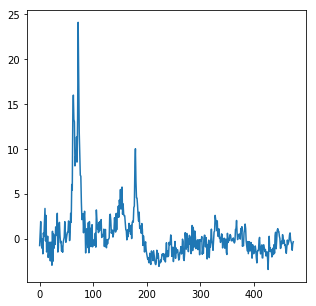

In [3]:
plt.figure(figsize=(5,5))
plt.plot(matDict['left'][3,:5].flatten())
plt.show()

##### Investigate baseline

The neuronal baseline will be computed as the n-th lowest percentile. User can validate the baseline selection by observing histograms of a few example cells 

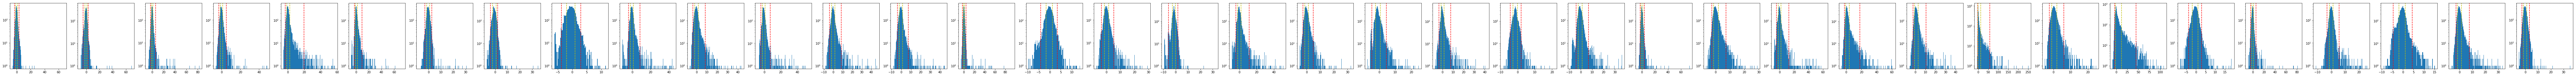

In [4]:
nCell, nTrial, nTime = matDict['left'].shape

fig, ax = plt.subplots(ncols = nCell, figsize=(4*nCell, 4))
for i in range(nCell):
    dataThis = matDict['left'][i].flatten()
    cut1 = np.percentile(dataThis, 2.3)
    cut2 = np.percentile(dataThis, 15.9)
    cut3 = np.percentile(dataThis, 84.1)
    cut4 = np.percentile(dataThis, 97.7)
    ax[i].hist(dataThis, bins='auto')
    ax[i].axvline(x=cut1, color='r', linestyle='--')
    ax[i].axvline(x=cut2, color='y', linestyle='--')
    ax[i].axvline(x=cut3, color='y', linestyle='--')
    ax[i].axvline(x=cut4, color='r', linestyle='--')
    ax[i].set_yscale('log')
plt.show()

## Ordering for data

1. Subtract minimum and normalize
2. Compute CDF
3. Subtract CDF and integrate

**TODO**:
* Try separate cells that are unorderable compared to everything (not sure how)
* Try from another period(delay vs action vs ...)
* Try predict behaviour (turn left-right) from orderable vs unorderable cells

Processing data (nCell, nTrial, nTime) = (38, 74, 95)
Mean order param 0.42681942255199723
Number above 1% 0.6557610241820768
Processing data (nCell, nTrial, nTime) = (31, 59, 95)
Mean order param 0.42985237834882445
Number above 1% 0.6516129032258065


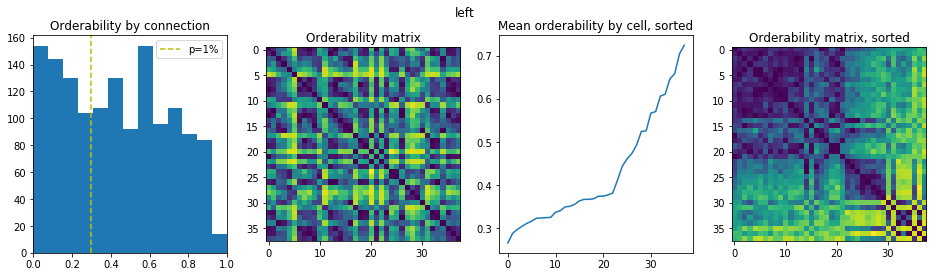

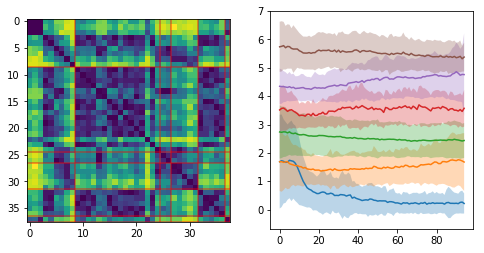

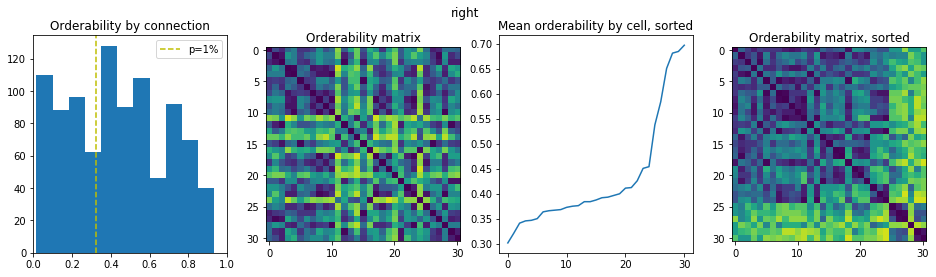

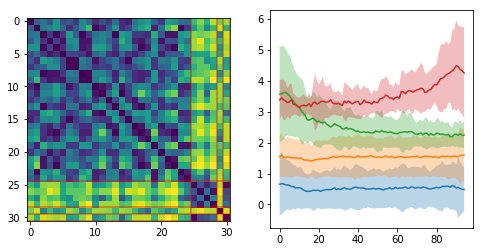

In [5]:
percentileBaseline = 30 # Out of 100
nClusterAim = [7, 5]            # Determines number of clusters
thrBivar = [0.297, 0.322]       # Bivariate order statistic threshold for p=[5%, 1%]
thrMulti = [0.12, 0.135]        # Multivariate order statistic threshold for p=[5%, 1%]

for iDataSet, (dataLabel, dataMat) in enumerate(matDict.items()):
    ###########################
    # Sorting
    ###########################
    
    # Rescale original data
    matRescaled = np.copy(dataMat)
    nCell, nTrial, nTime = matRescaled.shape
    print("Processing data (nCell, nTrial, nTime) =", matRescaled.shape)

    comparisonsByTrial = np.zeros((nTrial, nCell, nCell))
    for iTrial in range(nTrial):
        # Rescale all data for this trial
        for iCell in range(nCell):
            matRescaled[iCell, iTrial] = rescale(matRescaled[iCell, iTrial], percentileBaseline)
        comparisonsByTrial[iTrial] = order_func(matRescaled[:, iTrial])

    # Compute order metric for every 
    metricByConn = order_metric(comparisonsByTrial)
    
    # Make orderability plots
    orderability_plots(metricByConn, thrBivar[iDataSet])
    
    ###########################
    # Clustering
    ###########################
    
    # Perform clustering
    clustering = cluster_dist_matrix(metricByConn, nClusterAim[iDataSet])  # Cluster index for each node
    
    # Construct clustering plots
    clustering_plots(matRescaled, metricByConn, clustering)
        
plt.show()

## Validation V1

Cycle all signals by a random number

Processing data (nCell, nTrial, nTime) = (38, 74, 95)
1% cutoff 0.2432432432432432
Mean order param 0.0874245511514359
Number above 1% 0.008534850640113799
Processing data (nCell, nTrial, nTime) = (31, 59, 95)
1% cutoff 0.2542372881355932
Mean order param 0.08656825223254964
Number above 1% 0.002150537634408602


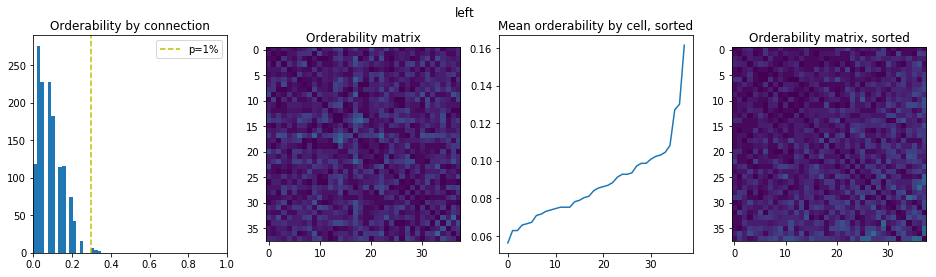

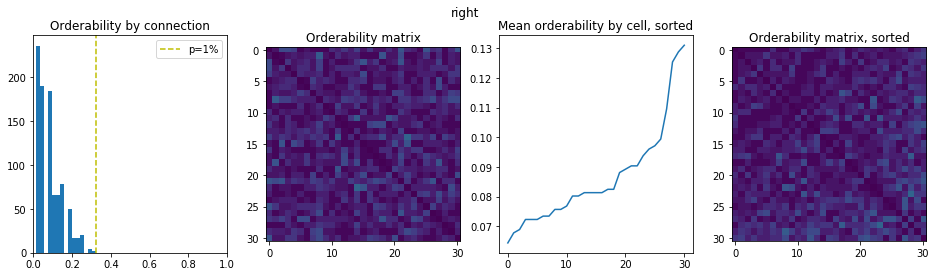

In [6]:
percentileBaseline = 30 # Out of 100
thrBivar = [0.297, 0.322]       # Bivariate order statistic threshold for p=[5%, 1%]

for iDataSet, (dataLabel, dataMat) in enumerate(matDict.items()):
    ###########################
    # Sorting
    ###########################
    
    # Rescale original data
    matRescaled = np.copy(dataMat)
    nCell, nTrial, nTime = matRescaled.shape
    print("Processing data (nCell, nTrial, nTime) =", matRescaled.shape)

    comparisonsByTrial = np.zeros((nTrial, nCell, nCell))
    for iCell in range(nCell):
        for iTrial in range(nTrial):    
            matRescaled[iCell, iTrial] = rescale(matRescaled[iCell, iTrial], percentileBaseline)
            
            # Add cycling
            nCycle = np.random.randint(0, nTime)
            matRescaled[iCell, iTrial] = cycle_data(matRescaled[iCell, iTrial], nCycle)
        
    for iTrial in range(nTrial):        
        comparisonsByTrial[iTrial] = order_func(matRescaled[:, iTrial])

    # Compute order metric for every 
    metricByConn = order_metric(comparisonsByTrial)
    
    print("1% cutoff", np.percentile(metricByConn[~np.eye(nCell, dtype=bool)], 99))
    
    # Make orderability plots
    orderability_plots(metricByConn, thrBivar[iDataSet])
        
plt.show()

# Validation 2

Shuffle each trial by cells

Processing data (nCell, nTrial, nTime) = (38, 74, 95)
1% cutoff 0.32432432432432434
Mean order param 0.10118795894044827
Number above 1% 0.021337126600284494
Processing data (nCell, nTrial, nTime) = (31, 59, 95)
1% cutoff 0.2881355932203389
Mean order param 0.08970293420812829
Number above 1% 0.002150537634408602


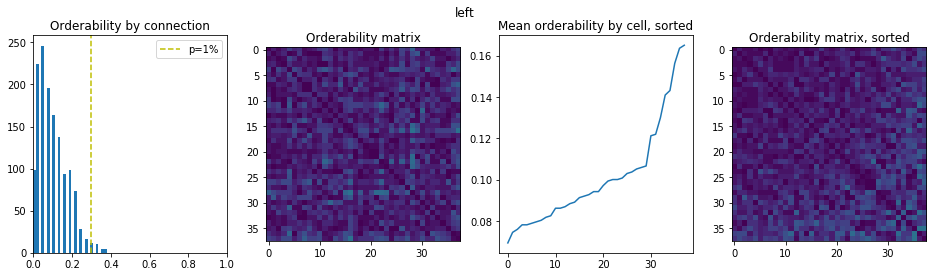

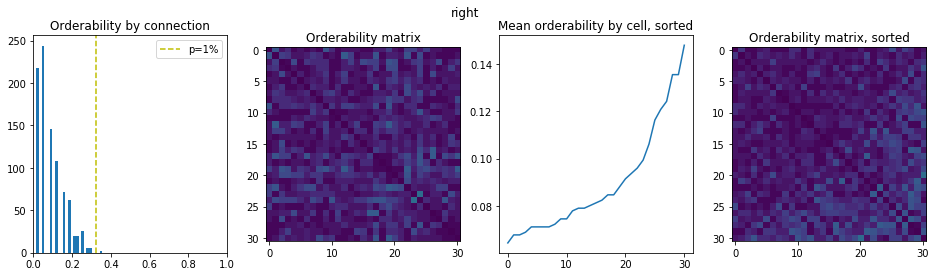

In [7]:
percentileBaseline = 30 # Out of 100
thrBivar = [0.297, 0.322]       # Bivariate order statistic threshold for p=[5%, 1%]

for iDataSet, (dataLabel, dataMat) in enumerate(matDict.items()):
    ###########################
    # Sorting
    ###########################
    
    # Rescale original data
    matRescaled = np.copy(dataMat)
    nCell, nTrial, nTime = matRescaled.shape
    print("Processing data (nCell, nTrial, nTime) =", matRescaled.shape)

    comparisonsByTrial = np.zeros((nTrial, nCell, nCell))
    for iTrial in range(nTrial):    
        for iCell in range(nCell):
            matRescaled[iCell, iTrial] = rescale(matRescaled[iCell, iTrial], percentileBaseline)
            
        cellPerm = np.random.permutation(nCell)
        comparisonsByTrial[iTrial] = order_func(matRescaled[cellPerm, iTrial])

    # Compute order metric for every 
    metricByConn = order_metric(comparisonsByTrial)
    
    print("1% cutoff", np.percentile(metricByConn[~np.eye(nCell, dtype=bool)], 99))
    
    # Make orderability plots
    orderability_plots(metricByConn, thrBivar[iDataSet])
        
plt.show()